## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [25]:
import tensorflow as tf
import uuid
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import math
import warnings
import rasterio
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW


%matplotlib inline
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# XVIEW_RECOGNITION_PATH = "./data/xview_recognition/"
XVIEW_RECOGNITION_PATH = "/workspace/COMPUTERVISIONPROYECT/data/xview_recognition"

## Hyperparameters
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.3
REGULARIZER_PENALTY = 1e-5
EPOCHS = 50

categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

# Required classes and functions

In [4]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

# 0. La usamos para las imágenes de test
def load_geoimage(filename_tensor):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    filename = filename_tensor
    src_raster = rasterio.open(filename, 'r')

    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

# 1. Función para decodificar los ejemplos del archivo
def _parse_image_function(example_proto):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'category_id': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    
    features = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.decode_raw(features['image_raw'], out_type=tf.uint8)
    shape = [features['height'], features['width'], features['depth']]
    image = tf.reshape(image, shape)
    image = tf.cast(image, tf.float32)
    
    image = tf.image.resize(image, [224, 224])
    
    category_id = tf.cast(features['category_id'], tf.int32)
    label = tf.one_hot(category_id, depth=len(categories))
    
    return image, label

# 2. Función para crear el dataset
def create_tfrecord_dataset(filenames, batch_size, do_shuffle=False):
    # Lee los archivos TFRecord. Puede leer de múltiples archivos en paralelo.
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    
    if do_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:
train_dataset = create_tfrecord_dataset([os.path.join(XVIEW_RECOGNITION_PATH, 'train.tfrecord')], BATCH_SIZE, do_shuffle=True)
valid_dataset = create_tfrecord_dataset([os.path.join(XVIEW_RECOGNITION_PATH, 'validation.tfrecord')], BATCH_SIZE)

I0000 00:00:1759990349.470097    1544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759990349.470138    1544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759990349.470146    1544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759990349.636934    1544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1759990349.636969    1544 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-09

In [ ]:
print('Load model')

model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(LayerNormalization())
# Dense block 4
model.add(Dense(128, activation='gelu', kernel_regularizer=l2(REGULARIZER_PENALTY)))
model.add(LayerNormalization())
model.add(Dropout(DROPOUT_RATE))
# Output layer
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Load model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 layer_normalization (Layer  (None, 150528)            301056    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 layer_normalization_1 (Lay  (None, 128)               256       
 erNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13)      

In [ ]:
opt = AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping('val_loss', patience=10, verbose=1, restore_best_weights=True)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
print('Training model')
h = model.fit(train_dataset, 
              validation_data=valid_dataset, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model (using validation loss)
best_idx = int(np.argmin(h.history['val_loss']))
best_values = h.history['val_accuracy'][best_idx], h.history['val_loss'][best_idx]
print(
    f'''--------\n
    Best validation model
    - epoch: {str(best_idx + 1)}
    - val_acc: {str(best_values[0])}
    - val_loss: {str(best_values[1])}'''
)

Training model
Epoch 1/50


2025-10-09 06:12:40.492218: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a 

      1/Unknown - 3s 3s/step - loss: 3.7178 - accuracy: 0.0664

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


     66/Unknown - 13s 149ms/step - loss: 2.5474 - accuracy: 0.2485

2025-10-09 06:12:51.280864: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-09 06:12:51.280907: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_10]]
2025-10-09 06:12:51.280918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6127665709762767145
2025-10-09 06:12:51.280922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17948615035660041615
2025-10-09 06:12:51.280927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11276903733470626252
2025-10-09 06:12:51.280948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17166142686811661564



Epoch 1: val_loss improved from inf to 1.93784, saving model to model.keras


2025-10-09 06:12:52.986393: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-09 06:12:52.986459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4817253431145133223


66/66 [==============================] - 17s 208ms/step - loss: 2.5474 - accuracy: 0.2485 - val_loss: 1.9378 - val_accuracy: 0.3696 - lr: 0.0010
Epoch 2/50
65/66 [============================>.] - ETA: 0s - loss: 2.0143 - accuracy: 0.3347
Epoch 2: val_loss improved from 1.93784 to 1.78453, saving model to model.keras
66/66 [==============================] - 3s 50ms/step - loss: 2.0116 - accuracy: 0.3358 - val_loss: 1.7845 - val_accuracy: 0.4016 - lr: 0.0010
Epoch 3/50
64/66 [============================>.] - ETA: 0s - loss: 1.8586 - accuracy: 0.3754
Epoch 3: val_loss improved from 1.78453 to 1.69811, saving model to model.keras
66/66 [==============================] - 3s 45ms/step - loss: 1.8569 - accuracy: 0.3755 - val_loss: 1.6981 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 4/50
64/66 [============================>.] - ETA: 0s - loss: 1.7443 - accuracy: 0.4152
Epoch 4: val_loss improved from 1.69811 to 1.63813, saving model to model.keras
66/66 [==============================] - 4s 58m

2025-10-09 06:13:26.318861: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154153984 bytes after encountering the first element of size 154153984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


65/66 [============================>.] - ETA: 0s - loss: 1.3327 - accuracy: 0.5554
Epoch 12: val_loss improved from 1.40674 to 1.39315, saving model to model.keras
66/66 [==============================] - 3s 46ms/step - loss: 1.3309 - accuracy: 0.5562 - val_loss: 1.3932 - val_accuracy: 0.5493 - lr: 0.0010
Epoch 13/50
64/66 [============================>.] - ETA: 0s - loss: 1.3148 - accuracy: 0.5594
Epoch 13: val_loss did not improve from 1.39315
66/66 [==============================] - 2s 28ms/step - loss: 1.3151 - accuracy: 0.5589 - val_loss: 1.3996 - val_accuracy: 0.5509 - lr: 0.0010
Epoch 14/50
65/66 [============================>.] - ETA: 0s - loss: 1.2858 - accuracy: 0.5703
Epoch 14: val_loss improved from 1.39315 to 1.38814, saving model to model.keras
66/66 [==============================] - 3s 45ms/step - loss: 1.2848 - accuracy: 0.5703 - val_loss: 1.3881 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 15/50
64/66 [============================>.] - ETA: 0s - loss: 1.2636 - accuracy: 

#### Validation
Compute validation metrics.

In [12]:
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(LayerNormalization())
# Dense block 4
model.add(Dense(128, activation='gelu', kernel_regularizer=l2(REGULARIZER_PENALTY)))
model.add(LayerNormalization())
model.add(Dropout(DROPOUT_RATE))
# Output layer
model.add(Dense(len(categories), activation='softmax'))

model.summary()

model.load_weights('model.keras')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 layer_normalization_2 (Lay  (None, 150528)            301056    
 erNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               19267712  
                                                                 
 layer_normalization_3 (Lay  (None, 128)               256       
 erNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 13)               

In [14]:
valid_dataset = create_tfrecord_dataset([os.path.join(XVIEW_RECOGNITION_PATH, 'validation.tfrecord')], BATCH_SIZE)
predictions = model.predict(valid_dataset)
category_names = np.array(list(categories.values()))
y_pred = category_names[predictions.argmax(axis=1)]

y_true = []

for images_batch, labels_batch in valid_dataset:
    labels_np = labels_batch.numpy()
    
    true_indices = np.argmax(labels_np, axis=1)
    batch_labels = category_names[true_indices]
    
    y_true.extend(batch_labels)

8/8 [==============================] - 2s 171ms/step


2025-10-09 06:17:09.357175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1829211920768592459
2025-10-09 06:17:09.357240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11025972863993001196
2025-10-09 06:17:09.589376: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 154153984 bytes after encountering the first element of size 154153984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


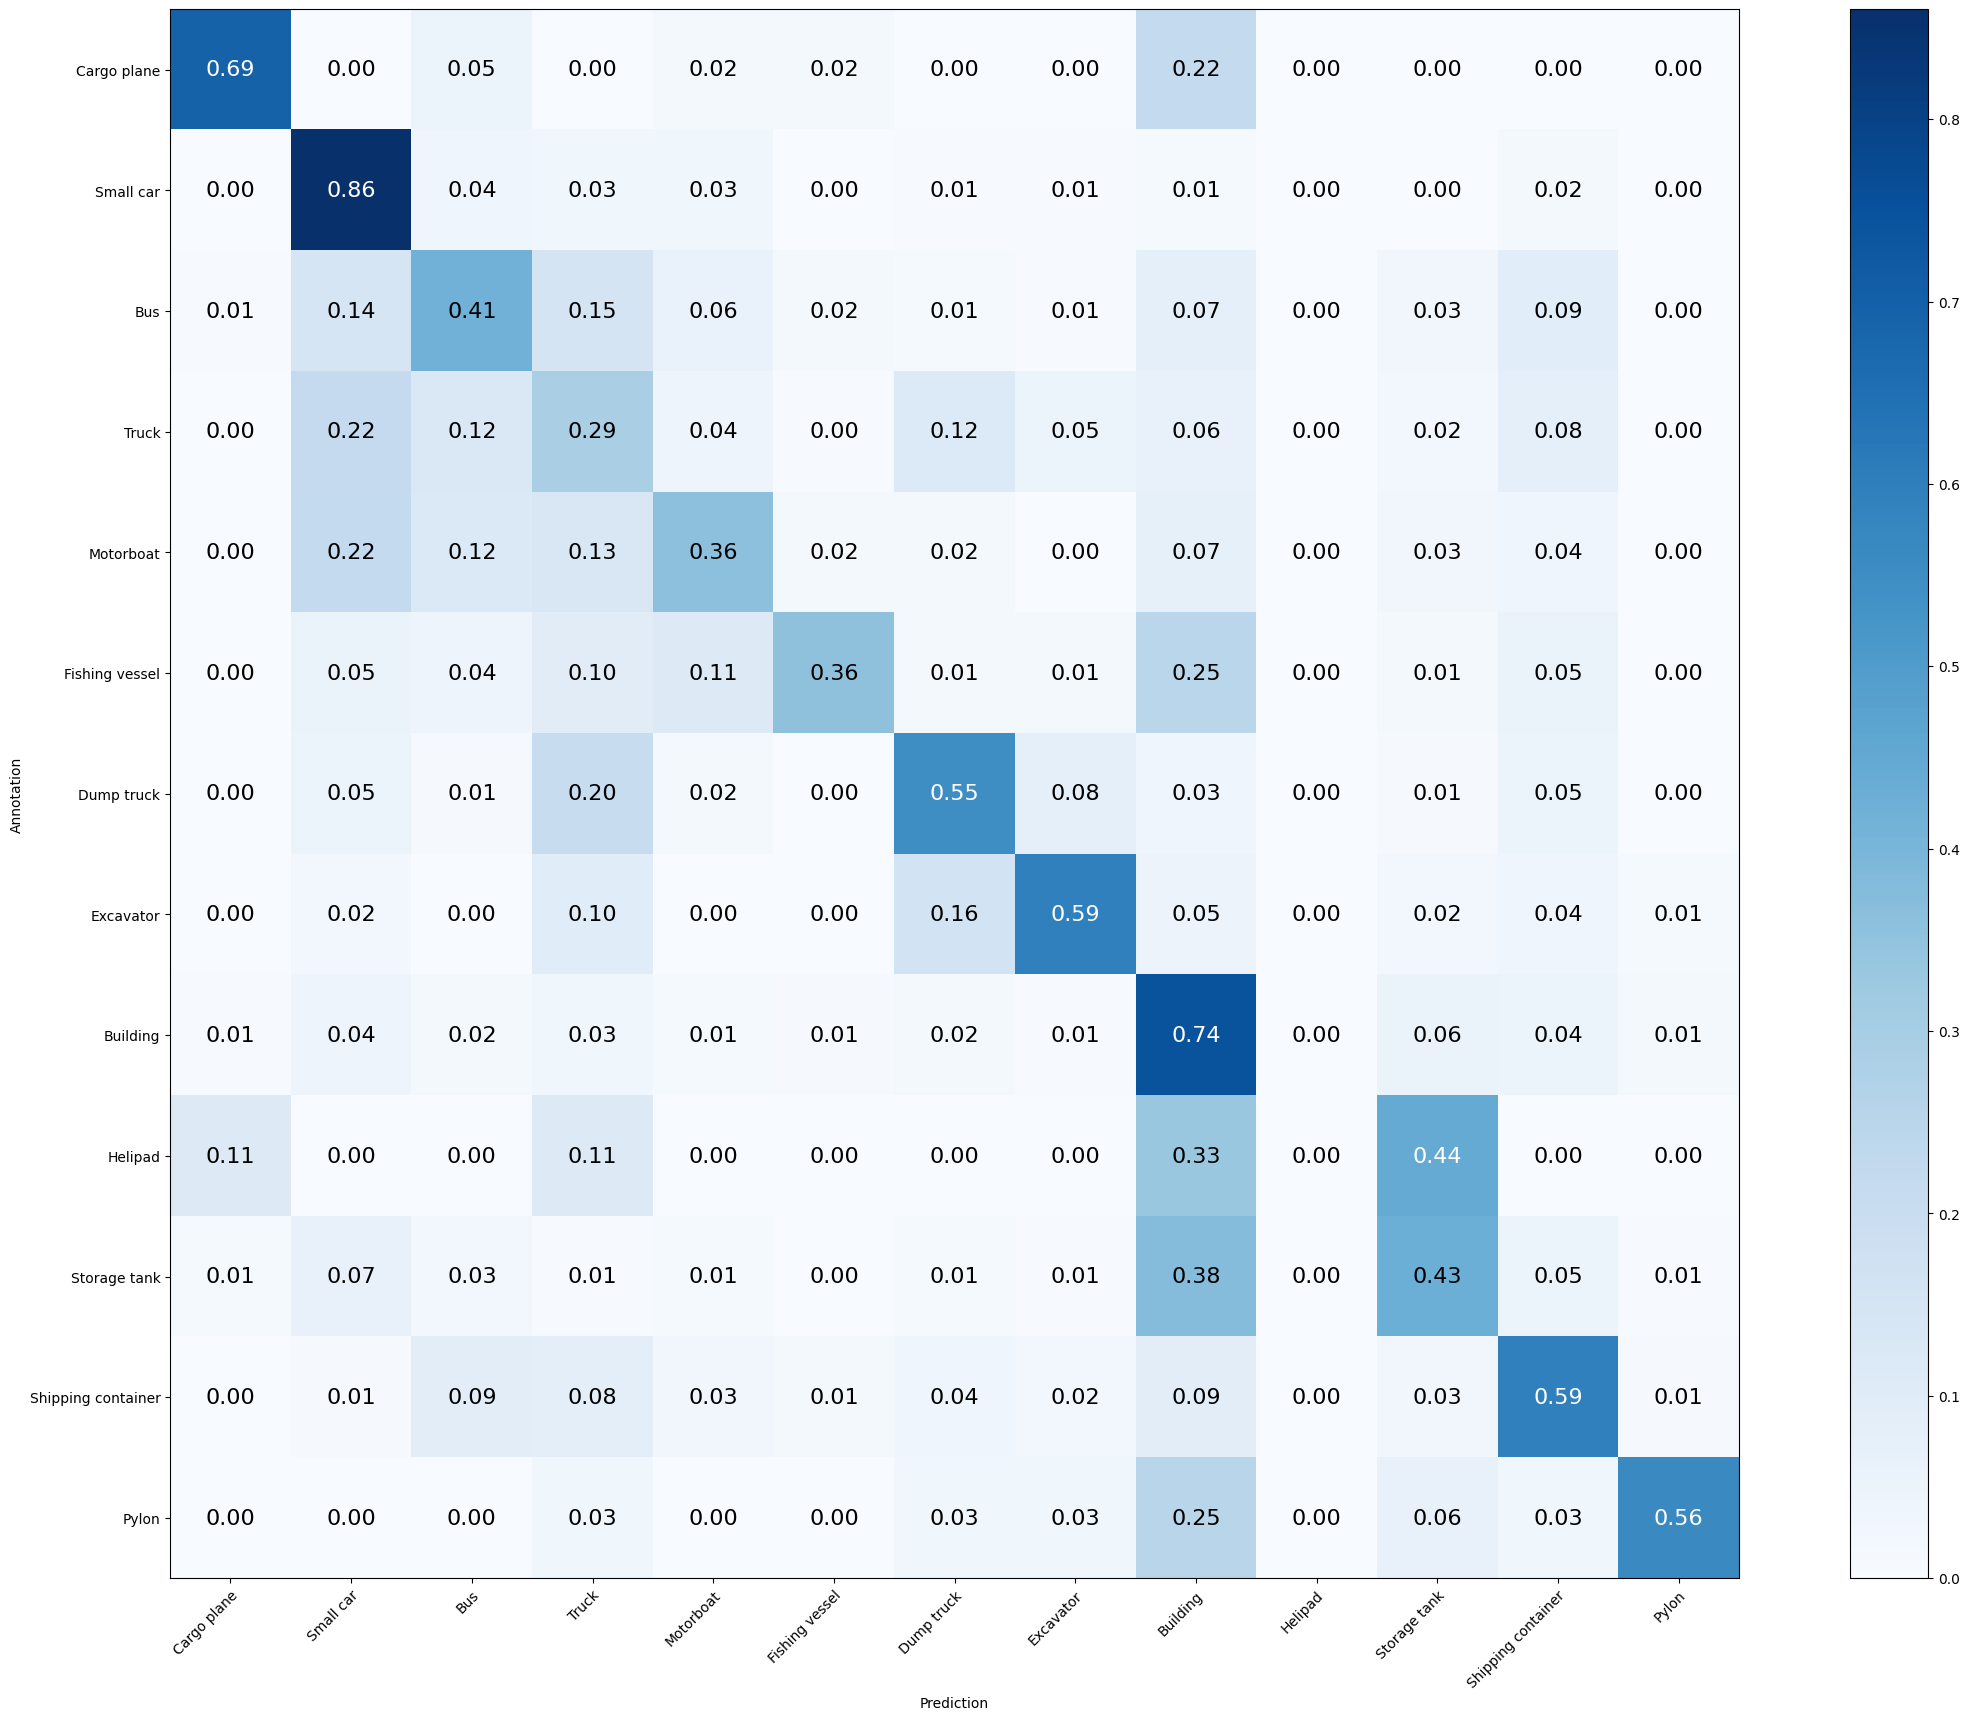

In [15]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 57.440%
Mean Recall: 49.564%
Mean Precision: 53.898%
> Cargo plane: Recall: 69.492% Precision: 87.234% Specificity: 99.670% Dice: 77.358%
> Small car: Recall: 86.018% Precision: 67.062% Specificity: 91.009% Dice: 75.366%
> Bus: Recall: 41.379% Precision: 45.860% Specificity: 95.003% Dice: 43.505%
> Truck: Recall: 29.046% Precision: 37.838% Specificity: 92.962% Dice: 32.864%
> Motorboat: Recall: 35.780% Precision: 43.333% Specificity: 97.112% Dice: 39.196%
> Fishing vessel: Recall: 35.616% Precision: 68.421% Specificity: 99.334% Dice: 46.847%
> Dump truck: Recall: 55.085% Precision: 50.781% Specificity: 96.414% Dice: 52.846%
> Excavator: Recall: 59.259% Precision: 60.759% Specificity: 98.272% Dice: 60.000%
> Building: Recall: 74.380% Precision: 62.937% Specificity: 89.484% Dice: 68.182%
> Helipad: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Storage tank: Recall: 42.763% Precision: 57.522% Specificity: 97.214% Dice: 49.057%
> Shipping container: R

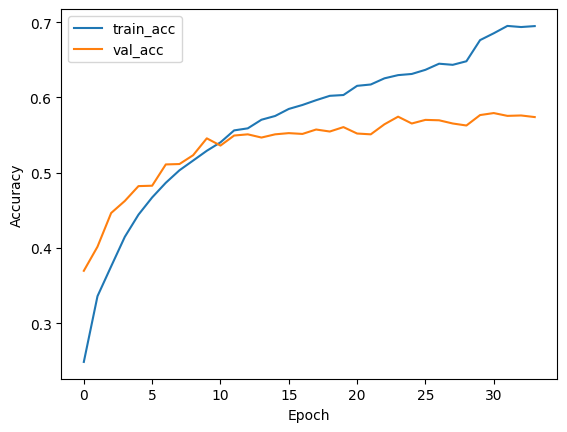

In [17]:
plt.plot(h.history['accuracy'], label='train_acc')
plt.plot(h.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

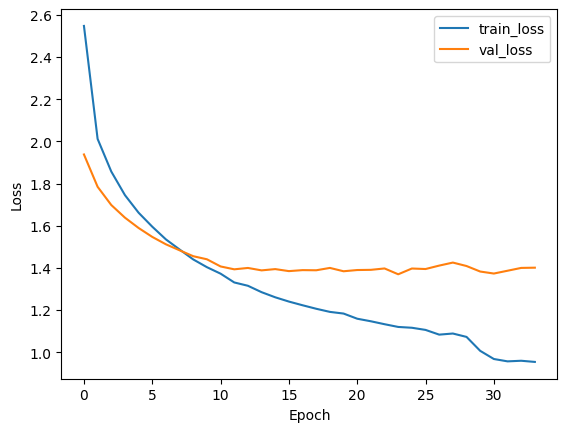

In [18]:
plt.plot(h.history['loss'], label='train_loss')
plt.plot(h.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the competition.

In [20]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(XVIEW_RECOGNITION_PATH, 'xview_recognition/xview_test')):
    for filename in filenames:
        image = GenericImage(os.path.join(dirpath,filename))
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 0


In [24]:
import numpy as np

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [26]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)